<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvsion_DCGAN_car_ex9_multiCarGen_Limg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現場で使える！　PyTorchPyTorch開発入門


##翔泳社

DCGAN

## 1.1 Google Drive をマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


# データ生成

no_imagだけ同じ画像をコピーする。そのうち、１バッチに1枚だけ別の画像を作っておく。

In [ ]:
  !pwd
  !ls -al bkcar_c
  

/content/drive/My Drive/Colab Notebooks/yolo_train
total 87
-rw------- 1 root root 13537 Nov  3 10:26 Audi_A3_2015_c.jpg
-rw------- 1 root root 14719 Nov  3 10:27 Audi_A3_2016_c.jpg
-rw------- 1 root root 14665 Nov  3 10:25 Audi_A3_c.jpg
-rw------- 1 root root 14371 Nov  3 10:28 Audi_A4_2011_c.jpg
-rw------- 1 root root 15834 Nov  3 10:28 Audi_A4_2014_c.jpg
-rw------- 1 root root 14619 Nov  3 10:29 Audi_A5_2010_AWD_c.jpg


In [3]:
!rm pspnet_car_data/jpg/*

In [ ]:
!rm -R acar/*

作為的にデータを生成

In [4]:
import shutil
import random

no_img = 2048
no_batch = 16

dir = "acar/"
savefile = "VW_c"

filename = "a4"
src = dir + filename + ".jpg"

for i in range(no_img):
  copy = "pspnet_car_data/jpg/"+ savefile + str(i) + ".jpg"
  shutil.copyfile(src,copy)


filename = "a3"
src = dir + filename + ".jpg"
print(int(no_img/no_batch))

for i in range(int(no_img/no_batch)):
  copy = "pspnet_car_data/jpg/"+ savefile + str( i * no_batch) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/"+ savefile + str( i * no_batch + 1) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/"+ savefile + str( i * no_batch + 2) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/"+ savefile + str( i * no_batch + 3) + ".jpg"
  shutil.copyfile(src,copy)

filename = "a2"
src = dir + filename + ".jpg"
print(int(no_img/no_batch))

for i in range(int(no_img/no_batch)):
  copy = "pspnet_car_data/jpg/"+ savefile + str( i * no_batch + 4) + ".jpg"
  shutil.copyfile(src,copy)
  copy = "pspnet_car_data/jpg/"+ savefile + str( i * no_batch + 5) + ".jpg"
  shutil.copyfile(src,copy)


#filename = "Audi_A5_2010_AWD_c"
#src = "bkcar_c/" + filename + ".jpg"

#for i in range(int(no_img/no_batch*2)):
  #rand = random.uniform(1, no_img)
  #rand = int(rand)
#  copy = "pspnet_car_data/jpg/Audi_c" + str(rand) + ".jpg"
  #shutil.copyfile(src,copy)



128
128


## 1.2 モジュール読み込み

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import copy

#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import save_image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111
Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


device(type='cuda', index=0)

##DCGANによる画像生成

Stanfrod Cars Datasetから選別した画像をセマンティックセグメンテーションにて車だけを抜き出し、背景を白色にした画像を用いる。

用いる画像ファイルの数を確認。

In [ ]:

DIR = 'pspnet_car_data/jpg/'

print(sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR)))

512


In [6]:
#img_data = ImageFolder("./stanford-car",
img_data = ImageFolder("./pspnet_car_data",
    transform=transforms.Compose([
        transforms.Resize(260),
#        transforms.Resize(140),
#        transforms.Resize(160),
        transforms.CenterCrop(256),
        transforms.ToTensor()
]))

#batch_size = 8
batch_size = 16
#batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

データの確認

In [ ]:
batch_iterator = iter(img_loader)
imges = next(batch_iterator)
print(imges[0].size())

torch.Size([16, 3, 256, 256])


画像生成モデル

In [7]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8,   
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 8, 
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, int(ngf / 2 ),
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(int(ngf / 2 )),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(int(ngf / 2), 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

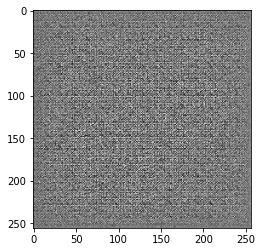

In [ ]:
# fake image の生成テスト
# 動作確認   【実際にはこのコードを走らせる必要はない】
import matplotlib.pyplot as plt
%matplotlib inline

G = GNet()

# 入力する乱数
input_z = torch.randn(1, 100)

# テンソルサイズを(1, 100, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [ ]:
# 動作確認   【実際にはこのコードを走らせる必要はない】
fake_images.size()

torch.Size([1, 3, 256, 256])

識別モデル

In [8]:
ndf = 128
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, int(ndf/2), 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(int(ndf/2), ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [ ]:
# 動作確認   【実際にはこのコードを走らせる必要はない】
# 動作確認
D = DNet()
#D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 100)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
print(fake_images.size())
# 偽画像をDに入力
d_out = D(fake_images)
print(d_out.size())
# 出力d_outにSigmoidをかけて0から1に変換
#print(nn.Sigmoid()(d_out))

torch.Size([1, 3, 256, 256])
torch.Size([])


訓練関数の作成

In [9]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [10]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
#    for real_img, _ in loader:
    for real_img, _ in tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)

        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)

        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()

    return mean(log_loss_g), mean(log_loss_d)

訓練開始

In [11]:

import datetime
num = "no21"  

for epoch in range(150):
    loss_g, loss_d = train_dcgan(g, d, opt_g, opt_d, img_loader)
    print("{} Epoch, {}, {}, {} ".format(datetime.datetime.now(), epoch, loss_g, loss_d))
    output_line = str(epoch) + "," + str(loss_g) + "," + str(loss_d)
    with  open('loss_result_' + num + '.csv', 'a') as f:
      f.writelines(output_line)
      f.writelines("\n")

    # 10回の繰り返しごとに学習結果を保存する
    if epoch % 10 == 0:
        # パラメータの保存
        #torch.save(
        #    g.state_dict(),
         #   "cars_train/g_{:03d}.prm".format(epoch),
          #  pickle_protocol=4)
        #torch.save(
         #   d.state_dict(),
          #  "cars_train/d_{:03d}.prm".format(epoch),
           # pickle_protocol=4)
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "./pspnet_car_data/" + num + "_oldcar_img256pxl_b16-{:03d}.jpg".format(epoch))

100%|██████████| 128/128 [00:34<00:00,  3.72it/s]


2021-11-24 04:52:47.732544 Epoch, 0, 4.831879559438676, 0.03234058262751205 


100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


2021-11-24 04:53:21.854857 Epoch, 1, 6.4956423826515675, 0.002257870329231082 


100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


2021-11-24 04:53:56.031546 Epoch, 2, 7.228138379752636, 0.0010789494160690083 


100%|██████████| 128/128 [00:34<00:00,  3.74it/s]


2021-11-24 04:54:30.279204 Epoch, 3, 8.023575119674206, 0.0005135701893550504 


100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


2021-11-24 04:55:04.219238 Epoch, 4, 8.443977262824774, 0.0003212091440900622 


100%|██████████| 128/128 [00:34<00:00,  3.76it/s]


2021-11-24 04:55:38.302889 Epoch, 5, 8.816958412528038, 0.00019843151108034363 


100%|██████████| 128/128 [00:34<00:00,  3.71it/s]


2021-11-24 04:56:12.798134 Epoch, 6, 9.095495454967022, 0.0001464525270193917 


100%|██████████| 128/128 [00:35<00:00,  3.61it/s]


2021-11-24 04:56:48.270652 Epoch, 7, 9.512226112186909, 9.892362294294799e-05 


100%|██████████| 128/128 [00:35<00:00,  3.61it/s]


2021-11-24 04:57:23.730563 Epoch, 8, 9.69546740502119, 8.672393411757184e-05 


100%|██████████| 128/128 [00:33<00:00,  3.79it/s]


2021-11-24 04:57:57.552596 Epoch, 9, 10.106382891535759, 7.748628639347999e-05 


100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


2021-11-24 04:58:31.511458 Epoch, 10, 8.665196866353654, 0.3115127824319899 


100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


2021-11-24 04:59:05.492608 Epoch, 11, 3.313461799350989, 0.5040272728037962 


100%|██████████| 128/128 [00:33<00:00,  3.79it/s]


2021-11-24 04:59:39.322182 Epoch, 12, 3.1740171798855954, 0.49642827914794907 


100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


2021-11-24 05:00:13.230542 Epoch, 13, 3.348873850403834, 0.7508052984048845 


100%|██████████| 128/128 [00:33<00:00,  3.81it/s]


2021-11-24 05:00:46.837571 Epoch, 14, 3.1786775936470804, 0.26801893685478717 


100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


2021-11-24 05:01:20.838391 Epoch, 15, 4.131873158272356, 0.12377069812646369 


100%|██████████| 128/128 [00:33<00:00,  3.82it/s]


2021-11-24 05:01:54.399954 Epoch, 16, 4.368889596124063, 0.14445083789905766 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 05:02:27.569780 Epoch, 17, 4.4595603523775935, 0.03399228949274402 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 05:03:00.653619 Epoch, 18, 4.139551167432231, 0.17457118926540716 


100%|██████████| 128/128 [00:33<00:00,  3.79it/s]


2021-11-24 05:03:34.413126 Epoch, 19, 4.97646368527171, 0.12126570855616592 


100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


2021-11-24 05:04:08.539815 Epoch, 20, 4.011499562300742, 0.050800136079487856 


100%|██████████| 128/128 [00:33<00:00,  3.81it/s]


2021-11-24 05:04:42.282217 Epoch, 21, 4.674115059431642, 0.08965503690342302 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:05:15.557151 Epoch, 22, 4.923333605751395, 0.021713936217565788 


100%|██████████| 128/128 [00:33<00:00,  3.81it/s]


2021-11-24 05:05:49.176698 Epoch, 23, 5.4215898513793945, 0.011068294761571451 


100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


2021-11-24 05:06:23.093352 Epoch, 24, 5.282194217666984, 0.013755657990259351 


100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


2021-11-24 05:06:56.994571 Epoch, 25, 5.125022607666324, 0.10810551500799193 


100%|██████████| 128/128 [00:34<00:00,  3.76it/s]


2021-11-24 05:07:31.097707 Epoch, 26, 4.856787959113717, 0.019306464868350304 


100%|██████████| 128/128 [00:33<00:00,  3.79it/s]


2021-11-24 05:08:04.905757 Epoch, 27, 5.729963976889849, 0.009150710648100358 


100%|██████████| 128/128 [00:33<00:00,  3.81it/s]


2021-11-24 05:08:38.516617 Epoch, 28, 6.207626774907112, 0.0038746802965761162 


100%|██████████| 128/128 [00:34<00:00,  3.76it/s]


2021-11-24 05:09:12.563290 Epoch, 29, 6.0621541403234005, 0.004246346050422289 


100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


2021-11-24 05:09:46.471917 Epoch, 30, 6.793617583811283, 0.0019596241963881766 


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


2021-11-24 05:10:20.053169 Epoch, 31, 7.100648403167725, 0.0015877618193371745 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 05:10:53.453069 Epoch, 32, 7.251682050526142, 0.0019520683999871835 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 05:11:26.833518 Epoch, 33, 8.01664375141263, 0.0006882726415824436 


100%|██████████| 128/128 [00:32<00:00,  3.88it/s]


2021-11-24 05:11:59.798317 Epoch, 34, 8.545640908181667, 0.00037793389833495894 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:12:32.757208 Epoch, 35, 8.715670369565487, 0.0003462077415861131 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:13:06.050107 Epoch, 36, 8.706827733665705, 0.00029896412547714135 


100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


2021-11-24 05:13:40.052291 Epoch, 37, 8.996618025004864, 0.0002224631803073862 


100%|██████████| 128/128 [00:33<00:00,  3.82it/s]


2021-11-24 05:14:13.592073 Epoch, 38, 8.863916724920273, 0.00023552114328140306 


100%|██████████| 128/128 [00:33<00:00,  3.82it/s]


2021-11-24 05:14:47.140898 Epoch, 39, 8.951100334525108, 0.00020520051526773386 


100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


2021-11-24 05:15:21.153975 Epoch, 40, 9.229568719863892, 0.0001814316404420424 


100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


2021-11-24 05:15:55.388551 Epoch, 41, 9.546599052846432, 0.00014637253957516805 


100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


2021-11-24 05:16:29.574498 Epoch, 42, 9.68054586648941, 0.00010802609648408179 


100%|██████████| 128/128 [00:33<00:00,  3.80it/s]


2021-11-24 05:17:03.250858 Epoch, 43, 9.476114317774773, 0.00014275333018076708 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 05:17:36.606359 Epoch, 44, 9.354676246643066, 0.00012467930932302806 


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


2021-11-24 05:18:10.025814 Epoch, 45, 9.3482196778059, 0.00013194341784128483 


100%|██████████| 128/128 [00:33<00:00,  3.80it/s]


2021-11-24 05:18:43.771107 Epoch, 46, 8.854772128164768, 0.00020761827710202851 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:19:17.005234 Epoch, 47, 9.074524983763695, 0.0002079916330899323 


100%|██████████| 128/128 [00:32<00:00,  3.88it/s]


2021-11-24 05:19:50.012449 Epoch, 48, 9.523281522095203, 0.00013773330647381954 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 05:20:23.227618 Epoch, 49, 9.326603069901466, 0.00015683411118061485 


100%|██████████| 128/128 [00:32<00:00,  3.91it/s]


2021-11-24 05:20:55.949420 Epoch, 50, 8.953351087868214, 0.00023251578556937602 


100%|██████████| 128/128 [00:32<00:00,  3.90it/s]


2021-11-24 05:21:28.905539 Epoch, 51, 8.630991250145598, 0.300960366955735 


100%|██████████| 128/128 [00:32<00:00,  3.92it/s]


2021-11-24 05:22:01.561302 Epoch, 52, 4.745610670186579, 0.04692732693183643 


100%|██████████| 128/128 [00:32<00:00,  3.91it/s]


2021-11-24 05:22:34.291096 Epoch, 53, 5.420153129845858, 0.010380431855082861 


100%|██████████| 128/128 [00:32<00:00,  3.92it/s]


2021-11-24 05:23:06.961153 Epoch, 54, 6.361933991312981, 0.003398543005459942 


100%|██████████| 128/128 [00:32<00:00,  3.90it/s]


2021-11-24 05:23:39.808017 Epoch, 55, 6.3091432601213455, 0.011428296242229408 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:24:12.691456 Epoch, 56, 5.9623571671545506, 0.007693568294598663 


100%|██████████| 128/128 [00:32<00:00,  3.92it/s]


2021-11-24 05:24:45.345619 Epoch, 57, 5.683847453030467, 0.12007355115474638 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 05:25:18.440669 Epoch, 58, 5.413669932633638, 0.011576347918889951 


100%|██████████| 128/128 [00:33<00:00,  3.88it/s]


2021-11-24 05:25:51.486896 Epoch, 59, 4.958054948947392, 0.3747657644908031 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 05:26:24.608556 Epoch, 60, 3.0294773598106985, 0.5438912279641954 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 05:26:57.928391 Epoch, 61, 3.519816546991933, 0.46141289951629005 


100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


2021-11-24 05:27:32.059447 Epoch, 62, 4.070039151585661, 0.3058628318613046 


100%|██████████| 128/128 [00:34<00:00,  3.76it/s]


2021-11-24 05:28:06.125321 Epoch, 63, 3.9834668764378875, 0.3894587451068219 


100%|██████████| 128/128 [00:33<00:00,  3.80it/s]


2021-11-24 05:28:39.809981 Epoch, 64, 4.091678245458752, 0.4123537792620482 


100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


2021-11-24 05:29:13.783823 Epoch, 65, 4.794857039349154, 0.334525317302905 


100%|██████████| 128/128 [00:33<00:00,  3.79it/s]


2021-11-24 05:29:47.610448 Epoch, 66, 3.8086132823955268, 0.3287026076213806 


100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


2021-11-24 05:30:21.474338 Epoch, 67, 4.130294364233123, 0.34781106213631574 


100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


2021-11-24 05:30:55.414022 Epoch, 68, 4.500609610578977, 0.19741381479252595 


100%|██████████| 128/128 [00:34<00:00,  3.76it/s]


2021-11-24 05:31:29.454282 Epoch, 69, 4.348350192653015, 0.3581654569497914 


100%|██████████| 128/128 [00:33<00:00,  3.82it/s]


2021-11-24 05:32:02.960290 Epoch, 70, 4.55974668849376, 0.3061168733838713 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 05:32:36.137872 Epoch, 71, 4.495559894887265, 0.27349454090290237 


100%|██████████| 128/128 [00:32<00:00,  3.90it/s]


2021-11-24 05:33:09.000863 Epoch, 72, 4.488403546914924, 0.2860306416769163 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:33:42.282894 Epoch, 73, 4.492753785918467, 0.3844627948856214 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 05:34:15.355248 Epoch, 74, 4.870113672921434, 0.33074136438881396 


100%|██████████| 128/128 [00:32<00:00,  3.88it/s]


2021-11-24 05:34:48.357080 Epoch, 75, 5.028820978710428, 0.21367253323842306 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 05:35:21.487750 Epoch, 76, 4.921034564438742, 0.27989965177403064 


100%|██████████| 128/128 [00:32<00:00,  3.90it/s]


2021-11-24 05:35:54.333627 Epoch, 77, 4.971220527775586, 0.2948232035814726 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 05:36:27.488038 Epoch, 78, 4.96984962746501, 0.19485304689442273 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:37:00.423681 Epoch, 79, 4.449823487957474, 0.3569423391709279 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:37:33.382090 Epoch, 80, 4.958582361927256, 0.2575210613395029 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 05:38:06.549222 Epoch, 81, 4.944468081230298, 0.33584258915288956 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 05:38:39.717876 Epoch, 82, 5.09212319663493, 0.22424963315461355 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:39:12.988110 Epoch, 83, 4.1420292283874005, 0.4506727720363415 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:39:46.228378 Epoch, 84, 3.50959877675632, 0.5592894651490496 


100%|██████████| 128/128 [00:32<00:00,  3.90it/s]


2021-11-24 05:40:19.053405 Epoch, 85, 4.696653666876955, 0.1801983211116749 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:40:51.964242 Epoch, 86, 4.9565272104227915, 0.31398617669401574 


100%|██████████| 128/128 [00:32<00:00,  3.88it/s]


2021-11-24 05:41:24.955075 Epoch, 87, 5.559858267195523, 0.11811910898177302 


100%|██████████| 128/128 [00:32<00:00,  3.88it/s]


2021-11-24 05:41:57.932020 Epoch, 88, 4.758870149511495, 0.2603233990012086 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:42:30.892001 Epoch, 89, 5.648977343924344, 0.2525968710451707 


100%|██████████| 128/128 [00:32<00:00,  3.91it/s]


2021-11-24 05:43:03.692966 Epoch, 90, 5.148810634855181, 0.28842961828377156 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:43:37.052378 Epoch, 91, 6.041756973136216, 0.28840121417306364 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 05:44:10.195873 Epoch, 92, 4.826215838402277, 0.32684597008119454 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 05:44:43.335819 Epoch, 93, 6.540563468821347, 0.033443032238210435 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:45:16.273486 Epoch, 94, 5.83170367218554, 0.01999232366506476 


100%|██████████| 128/128 [00:32<00:00,  3.91it/s]


2021-11-24 05:45:49.058854 Epoch, 95, 5.993917841464281, 0.00968426338658901 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:46:22.004341 Epoch, 96, 6.312602397054434, 0.005297564846841851 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:46:54.967262 Epoch, 97, 6.652217771857977, 0.003836310875158233 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:47:28.273601 Epoch, 98, 7.238621266253176, 0.09268644081907951 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 05:48:01.482403 Epoch, 99, 4.84972088757786, 0.30489954796939855 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 05:48:34.861776 Epoch, 100, 4.735984348815691, 0.3460242262772226 


100%|██████████| 128/128 [00:33<00:00,  3.88it/s]


2021-11-24 05:49:08.002513 Epoch, 101, 5.638846674759407, 0.12985744581965264 


100%|██████████| 128/128 [00:33<00:00,  3.82it/s]


2021-11-24 05:49:41.566517 Epoch, 102, 5.588940050918609, 0.20496233270750963 


100%|██████████| 128/128 [00:33<00:00,  3.82it/s]


2021-11-24 05:50:15.106451 Epoch, 103, 6.351944992784411, 0.08876183293341455 


100%|██████████| 128/128 [00:33<00:00,  3.81it/s]


2021-11-24 05:50:48.703477 Epoch, 104, 5.081169906547075, 0.4758095353136014 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 05:51:22.064290 Epoch, 105, 5.412015213165432, 0.24075046127836686 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 05:51:55.423850 Epoch, 106, 5.9184455204813275, 0.17723272602597717 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:52:28.724736 Epoch, 107, 5.5208792390767485, 0.30047163202107185 


100%|██████████| 128/128 [00:33<00:00,  3.82it/s]


2021-11-24 05:53:02.242225 Epoch, 108, 6.183992028236389, 0.022259155495703453 


100%|██████████| 128/128 [00:33<00:00,  3.81it/s]


2021-11-24 05:53:35.850876 Epoch, 109, 6.7218493558466434, 0.010953392153169261 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 05:54:09.219437 Epoch, 110, 7.245870012789965, 0.005163229821391724 


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


2021-11-24 05:54:42.814357 Epoch, 111, 7.765078898519278, 0.0032439374203931948 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 05:55:16.139514 Epoch, 112, 6.1306404743427265, 0.6543809728996166 


100%|██████████| 128/128 [00:33<00:00,  3.80it/s]


2021-11-24 05:55:49.825827 Epoch, 113, 3.5375294690893497, 0.4720825187250739 


100%|██████████| 128/128 [00:33<00:00,  3.78it/s]


2021-11-24 05:56:23.740925 Epoch, 114, 4.614051909036789, 0.3168255128330202 


100%|██████████| 128/128 [00:33<00:00,  3.80it/s]


2021-11-24 05:56:57.435708 Epoch, 115, 5.658663796726614, 0.21426177847934014 


100%|██████████| 128/128 [00:33<00:00,  3.82it/s]


2021-11-24 05:57:30.966793 Epoch, 116, 5.044171383662615, 0.2571673385609756 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:58:04.210983 Epoch, 117, 6.151777838706039, 0.10923208695749054 


100%|██████████| 128/128 [00:32<00:00,  3.89it/s]


2021-11-24 05:58:37.123047 Epoch, 118, 5.356380342935154, 0.3149971766943054 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 05:59:10.285065 Epoch, 119, 6.5987867375370115, 0.18337175380202098 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 05:59:43.572723 Epoch, 120, 4.429348223726265, 0.2617667741214973 


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


2021-11-24 06:00:17.106708 Epoch, 121, 6.820383698679507, 0.017868889961391687 


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


2021-11-24 06:00:50.520975 Epoch, 122, 3.8009708582712847, 0.47105955634106067 


100%|██████████| 128/128 [00:33<00:00,  3.81it/s]


2021-11-24 06:01:24.124033 Epoch, 123, 5.408168200054206, 0.22107594506360329 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 06:01:57.258822 Epoch, 124, 6.2861311617307365, 0.13550188067983981 


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


2021-11-24 06:02:30.686163 Epoch, 125, 7.636631077155471, 0.015771643269545166 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 06:03:04.032607 Epoch, 126, 4.784545282396721, 0.541075367555095 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 06:03:37.378415 Epoch, 127, 6.3135936986655, 0.021644063562234805 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 06:04:10.557737 Epoch, 128, 6.508321423083544, 0.010787905021061306 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 06:04:43.809599 Epoch, 129, 7.047901066020131, 0.007957265659570112 


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


2021-11-24 06:05:17.209762 Epoch, 130, 7.549703743308783, 0.007483769803457108 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 06:05:50.550164 Epoch, 131, 2.765539308584266, 0.7872821453638608 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 06:06:23.916395 Epoch, 132, 4.212046867702156, 0.36102786312039825 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 06:06:57.037733 Epoch, 133, 5.023105187457986, 0.33303051576876896 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 06:07:30.125886 Epoch, 134, 5.248415913491044, 0.2893711669676122 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 06:08:03.215337 Epoch, 135, 4.68329348298721, 0.35116635473968927 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 06:08:36.317889 Epoch, 136, 4.836603653384373, 0.19477620505858795 


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


2021-11-24 06:09:09.470214 Epoch, 137, 6.003564493183148, 0.21767706241325868 


100%|██████████| 128/128 [00:32<00:00,  3.88it/s]


2021-11-24 06:09:42.465613 Epoch, 138, 5.302660560118966, 0.2872754084719418 


100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


2021-11-24 06:10:15.599784 Epoch, 139, 6.212921857775655, 0.1963194053087136 


100%|██████████| 128/128 [00:33<00:00,  3.85it/s]


2021-11-24 06:10:48.887916 Epoch, 140, 6.9124080531764776, 0.05889653958593044 


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]


2021-11-24 06:11:22.392448 Epoch, 141, 6.800854183267802, 0.29904319272827706 


100%|██████████| 128/128 [00:33<00:00,  3.84it/s]


2021-11-24 06:11:55.782687 Epoch, 142, 5.17413791641593, 0.19296352449600818 


100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


2021-11-24 06:12:29.778074 Epoch, 143, 6.854626503729378, 0.17288856337427205 


100%|██████████| 128/128 [00:33<00:00,  3.81it/s]


2021-11-24 06:13:03.357361 Epoch, 144, 5.33946559659671, 0.17180295901107456 


100%|██████████| 128/128 [00:33<00:00,  3.80it/s]


2021-11-24 06:13:37.075583 Epoch, 145, 5.068198864842998, 0.46126917840592796 


100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


2021-11-24 06:14:11.700235 Epoch, 146, 6.971669868566096, 0.024035324227952515 


100%|██████████| 128/128 [00:34<00:00,  3.74it/s]


2021-11-24 06:14:45.917169 Epoch, 147, 7.701218672096729, 0.012611119255780068 


100%|██████████| 128/128 [00:34<00:00,  3.76it/s]


2021-11-24 06:15:19.995465 Epoch, 148, 6.003780231811106, 0.19295973639123076 


100%|██████████| 128/128 [00:33<00:00,  3.79it/s]

2021-11-24 06:15:53.819802 Epoch, 149, 6.88869039947167, 0.17826666311202644 


結果の表示

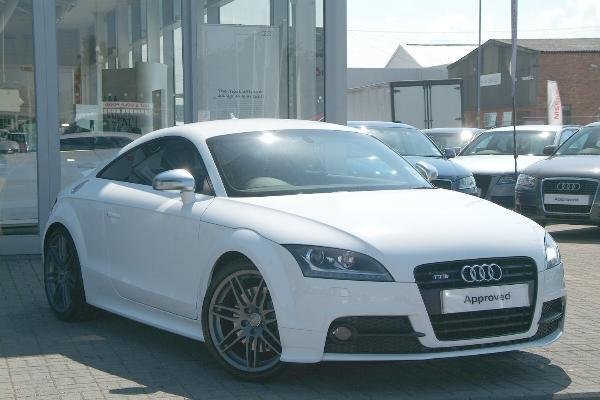

In [ ]:
from IPython.display import Image,display_jpeg
#display_jpeg(Image('cars_train/080.jpg'))
display_jpeg(Image('stanford-car/jpg/00001.jpg'))

In [ ]:
!ls -all